In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils, models
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

plt.rcParams.update({'axes.grid': False})

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: cuda


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/my-gan-wife/img/train/ta copy 4/IMG_2042.HEIC
/kaggle/input/my-gan-wife/img/train/ta copy 4/IMG_9469.HEIC
/kaggle/input/my-gan-wife/img/train/ta copy 4/IMG_4452.HEIC
/kaggle/input/my-gan-wife/img/train/ta copy 4/IMG_1772.HEIC
/kaggle/input/my-gan-wife/img/train/ta copy 4/IMG_0394.HEIC
/kaggle/input/my-gan-wife/img/train/ta copy 4/IMG_0293.JPG
/kaggle/input/my-gan-wife/img/train/ta copy 4/IMG_2247.JPG
/kaggle/input/my-gan-wife/img/train/ta copy 4/IMG_2671.HEIC
/kaggle/input/my-gan-wife/img/train/ta copy 4/IMG_4158.JPG
/kaggle/input/my-gan-wife/img/train/ta copy 4/IMG_9779.HEIC
/kaggle/input/my-gan-wife/img/train/ta copy 4/IMG_0393.HEIC
/kaggle/input/my-gan-wife/img/train/ta copy 4/IMG_1993.JPG
/kaggle/input/my-gan-wife/img/train/ta copy 4/E2E7DA0C-FC6C-436D-8039-284F78E769B6.JPG
/kaggle/input/my-gan-wife/img/train/ta copy 4/IMG_1872.JPG
/kaggle/input/my-gan-wife/img/train/ta copy 4/IMG_4454.heic
/kaggle/input/my-gan-wife/img/train/ta copy 4/IMG_3968.JPG
/kaggle/input/my-ga

Size of dataset: 224


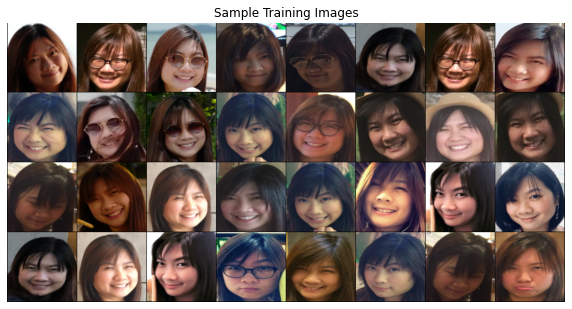

In [4]:
# Load data
DATA_DIR = "/kaggle/input/my-gan-wife/img/train"
# DATA_DIR = "../input/cat-breed/cat-breed/TRAIN"

IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root=DATA_DIR, transform=data_transforms)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
        
# Plot samples
sample_batch = next(iter(data_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True), (1, 2, 0)));

print(f'Size of dataset: {len(data_loader) * BATCH_SIZE}')

### 2.2: Create the Generator

In [5]:
class Generator(nn.Module):
    
    def __init__(self, LATENT_SIZE):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            
            # input dim: [-1, LATENT_SIZE, 1, 1]
            
            nn.ConvTranspose2d(LATENT_SIZE, 1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            # output dim: [-1, 1024, 4, 4]

            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # output dim: [-1, 512, 8, 8]

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # output dim: [-1, 256, 16, 16]

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # output dim: [-1, 128, 32, 32]
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # output dim: [-1, 64, 64, 64]

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(3),
            
            # output dim: [-1, 3, 128, 128]
            
            nn.Tanh()
            
            # output dim: [-1, 3, 128, 128]
        )
        
    def forward(self, input):
        output = self.main(input)
        return output

### 2.3: Create the Discriminator

In [6]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
        
            # input dim: [-1, 3, 128, 128]
            
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # output dim: [-1, 64, 64, 64]

            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # output dim: [-1, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # output dim: [-1, 128, 16, 16]

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # output dim: [-1, 256, 8, 8]

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # output dim: [-1, 512, 4, 4]

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            
            # output dim: [-1, 1, 1, 1]

            nn.Flatten(),
            
            # output dim: [-1]

            nn.Sigmoid()
            
            # output dim: [-1]
        )

    def forward(self, input):
        output = self.main(input)
        return output

### 2.4: Initialize Weights

GANs can be quite sensitive to the initial weights assigned to each layer when we instantiate the model. Instantiate your generator and discriminator and then specify their initial weights as follows:

- `Conv2d()` layers: normal distribution with `mean=0.0` and `std=0.02`

- `ConvTranspose2d()` layers: normal distribution with `mean=0.0` and `std=0.02`

- `BatchNorm2d()` layers: normal distribution with `mean=1.0` and `std=0.02` for the weights, zeroes for the biases

- Use `LATENT_SIZE = 100`

In [7]:
LATENT_SIZE = 100

generator = Generator(LATENT_SIZE)
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

criterion = nn.BCELoss()

optimizerG = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))

In [8]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
generator.apply(weights_init)
discriminator.apply(weights_init);

### 2.5: Train your GAN

You now have all the ingredients you need now to train a GAN, so give it a go!

You should track the loss of your model as epochs progress and show at least one example of an image output by your trained generator (better yet, record the evolution over time of how your generator is doing, like we did in Lecture 8). **Your results may not be great and that's perfectly okay, you should just show _something_**.

Here are some tips:

- You will likely need to train for at least `NUM_EPOCHS=100` (and maybe more).

- I find that the hardest part about training GANs is that the discriminator "overpowers" the generator, making it hard for the generator to learn how to create realistic images. There are lots of things you can do to try and balance your generator and discriminator, such as: play with the optimizer's hyperparameters, change the architectures of your models, etc.

- Here's a good set of [tips and tricks for training GANs](https://github.com/soumith/ganhacks).

- Once again, GANs are notoriously difficult to train (even more so with smaller data sets like we have here). Don't worry if you're not getting amazing results. This is all about practice.

In [9]:
img_list = []
fixed_noise = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1).to(device)

In [10]:
NUM_EPOCHS = 1000

print('Training started:\n')

D_real_epoch, D_fake_epoch, loss_dis_epoch, loss_gen_epoch = [], [], [], []

for epoch in range(NUM_EPOCHS):
    
    D_real_iter, D_fake_iter, loss_dis_iter, loss_gen_iter = [], [], [], []
    
    for real_batch, _ in data_loader:

        # STEP 1: train discriminator
        # ==================================
        # Train with real data
        discriminator.zero_grad()
        
        real_batch = real_batch.to(device)
        real_labels = torch.ones((real_batch.shape[0],), dtype=torch.float).to(device)
        
        output = discriminator(real_batch).view(-1)
        loss_real = criterion(output, real_labels)
        
        # Iteration book-keeping
        D_real_iter.append(output.mean().item())
        
        # Train with fake data
        noise = torch.randn(real_batch.shape[0], LATENT_SIZE, 1, 1).to(device)
        
        fake_batch = generator(noise)
        fake_labels = torch.zeros_like(real_labels)
        
        output = discriminator(fake_batch.detach()).view(-1)
        loss_fake = criterion(output, fake_labels)
        
        # Update discriminator weights
        loss_dis = loss_real + loss_fake
        loss_dis.backward()
        optimizerD.step()
        
        # Iteration book-keeping
        loss_dis_iter.append(loss_dis.mean().item())
        D_fake_iter.append(output.mean().item())
        
        # STEP 2: train generator
        # ==================================
        generator.zero_grad()
        output = discriminator(fake_batch).view(-1)
        loss_gen = criterion(output, real_labels)
        loss_gen.backward()
        
        # Book-keeping
        loss_gen_iter.append(loss_gen.mean().item())
        
        # Update generator weights and store loss
        optimizerG.step()
        
    print(f"Epoch ({epoch + 1}/{NUM_EPOCHS})\t",
          f"Loss_G: {np.mean(loss_gen_iter):.4f}",
          f"Loss_D: {np.mean(loss_dis_iter):.4f}\t",
          f"D_real: {np.mean(D_real_iter):.4f}",
          f"D_fake: {np.mean(D_fake_iter):.4f}")
    
    # Epoch book-keeping
    loss_gen_epoch.append(np.mean(loss_gen_iter))
    loss_dis_epoch.append(np.mean(loss_dis_iter))
    D_real_epoch.append(np.mean(D_real_iter))
    D_fake_epoch.append(np.mean(D_fake_iter))
    
    # Keeping track of the evolution of a fixed noise latent vector
    with torch.no_grad():
        fake_images = generator(fixed_noise).detach().cpu()
        img_list.append(utils.make_grid(fake_images, normalize=True, nrows=10))
        
print("\nTraining ended.")

Training started:

Epoch (1/1000)	 Loss_G: 23.4260 Loss_D: 11.2940	 D_real: 0.7931 D_fake: 0.4654
Epoch (2/1000)	 Loss_G: 24.5262 Loss_D: 13.1575	 D_real: 0.8712 D_fake: 0.3263
Epoch (3/1000)	 Loss_G: 12.5041 Loss_D: 4.3500	 D_real: 0.7851 D_fake: 0.2849
Epoch (4/1000)	 Loss_G: 9.2139 Loss_D: 0.7969	 D_real: 0.8824 D_fake: 0.1537
Epoch (5/1000)	 Loss_G: 7.2902 Loss_D: 0.9812	 D_real: 0.8610 D_fake: 0.1759
Epoch (6/1000)	 Loss_G: 7.6989 Loss_D: 0.7582	 D_real: 0.9494 D_fake: 0.2467
Epoch (7/1000)	 Loss_G: 6.0000 Loss_D: 1.6568	 D_real: 0.7943 D_fake: 0.1166
Epoch (8/1000)	 Loss_G: 5.4336 Loss_D: 1.3592	 D_real: 0.7993 D_fake: 0.1473
Epoch (9/1000)	 Loss_G: 5.0555 Loss_D: 0.5793	 D_real: 0.9130 D_fake: 0.2314
Epoch (10/1000)	 Loss_G: 5.0504 Loss_D: 1.8830	 D_real: 0.7714 D_fake: 0.2548
Epoch (11/1000)	 Loss_G: 4.2168 Loss_D: 0.6399	 D_real: 0.8330 D_fake: 0.1789
Epoch (12/1000)	 Loss_G: 5.9577 Loss_D: 1.5572	 D_real: 0.8063 D_fake: 0.3284
Epoch (13/1000)	 Loss_G: 3.9125 Loss_D: 1.3218	 D

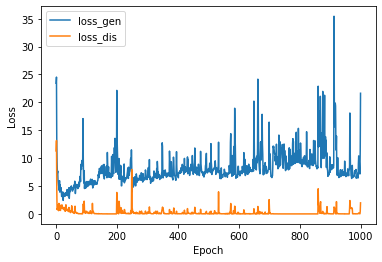

In [11]:
plt.plot(np.array(loss_gen_epoch), label='loss_gen')
plt.plot(np.array(loss_dis_epoch), label='loss_dis')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

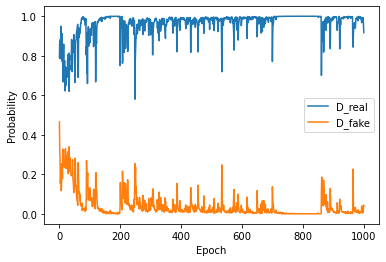

In [12]:
plt.plot(np.array(D_real_epoch), label='D_real')
plt.plot(np.array(D_fake_epoch), label='D_fake')
plt.xlabel("Epoch")
plt.ylabel("Probability")
plt.legend();

In [13]:
len(img_list[900:])

100

In [14]:
%%capture

fig = plt.figure(figsize=(10, 10))
# ims = [[plt.imshow(np.transpose(i,(1, 2, 0)), animated=True)] for i in img_list[::1]]
ims = [[plt.imshow(np.transpose(i,(1, 2, 0)), animated=True)] for i in img_list[800:900]]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save('wife800.gif', writer='imagemagick', fps=2)
HTML(ani.to_jshtml()) # run this in a new cell to produce the below animation

In [17]:
%%capture

fig = plt.figure(figsize=(10, 10))
# ims = [[plt.imshow(np.transpose(i,(1, 2, 0)), animated=True)] for i in img_list[::1]]
ims = [[plt.imshow(np.transpose(i,(1, 2, 0)), animated=True)] for i in img_list[900:]]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save('wife-100.gif', writer='imagemagick', fps=2)
HTML(ani.to_jshtml()) # run this in a new cell to produce the below animation

In [16]:
%%capture

fig = plt.figure(figsize=(10, 10))
# ims = [[plt.imshow(np.transpose(i,(1, 2, 0)), animated=True)] for i in img_list[::1]]
ims = [[plt.imshow(np.transpose(i,(1, 2, 0)), animated=True)] for i in img_list[-1:]]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save('wife800_final.gif', writer='imagemagick', fps=2)
HTML(ani.to_jshtml()) # run this in a new cell to produce the below animation